In [1]:
from datetime import datetime
from finance_utils.backtest import Backtest
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

name = 'SPY'

In [2]:
from_beginning = '1987-01-01'
start_date = from_beginning
df = yf.download(name, start=start_date)
df = df[['Adj Close']].copy()
df['Return'] = df['Adj Close'].pct_change().fillna(0)

# set time here
today = datetime.now()
last_10_years = f'{today.year - 9}-01-01'
last_20_years = f'{today.year - 19}-01-01'
last_30_years = f'{today.year - 29}-01-01'
start_date = f'1900-01-01'
choices = [last_10_years, last_20_years, last_30_years, start_date]

[*********************100%%**********************]  1 of 1 completed


In [3]:
def plot_graphs(main_df, _rolling_day, _time = from_beginning, show_ma = False):
    _new_df = main_df[main_df.index >= _time]
    _df_ = _new_df.groupby([_new_df.index.month, _new_df.index.day]).describe()['Rolling Return']
    
    _df_.index.names = ['Month', 'Day']
    _df_ = _df_.reset_index()
    
    _df_['Date'] = [
        f"2024-{_df_['Month'].iloc[i]}-{_df_['Day'].iloc[i]}" 
        for i in _df_.index
    ]
    
    _df_.set_index('Date', inplace=True)
    _df_.index = pd.to_datetime(_df_.index)

    # -- plot --
    plt.subplots(figsize=(10, 6))
    plt.plot(_df_.index, _df_['mean'] * 100, label='Mean', alpha=0.6, color=colours[0])
    plt.plot(_df_.index, _df_['50%'] * 100, label='Median', alpha=1, color=colours[1])
    plt.fill_between(_df_.index, _df_['25%'] * 100, _df_['50%'] * 100, label='Q1', alpha=0.2, color=colours[2])
    plt.fill_between(_df_.index, _df_['75%'] * 100, _df_['50%'] * 100, label='Q3', alpha=0.2, color=colours[3])

    if show_ma:
        ma = _df_['mean'].rolling(10).mean()
        plt.plot(ma * 100, label='MA 10')

    plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))
    plt.xlabel('Date')
    plt.ylabel('Return %')

    years = 1 + _new_df.index.year[-1] - _new_df.index.year[0]
    plt.title(f'{name} Rolling {_rolling_day} Days Cumulative Return, Last {years} Years')

    plt.grid(axis='y')
    plt.axhline(y=0, color='grey', alpha=0.5)
    plt.legend()
    plt.show()

    return _df_.copy() * 100


In [4]:
temp_list = []
for _df in df.rolling(63):
    first = _df['Adj Close'].iloc[0]
    last = _df['Adj Close'].iloc[-1]
    returns = (last - first) / first
    temp_list.append(returns)

df['Rolling Return'] = temp_list
df['Rolling Return'] = df['Rolling Return'].shift(-63)

In [5]:
df['Rolling Return'].tail()

Date
2024-08-09   NaN
2024-08-12   NaN
2024-08-13   NaN
2024-08-14   NaN
2024-08-15   NaN
Name: Rolling Return, dtype: float64

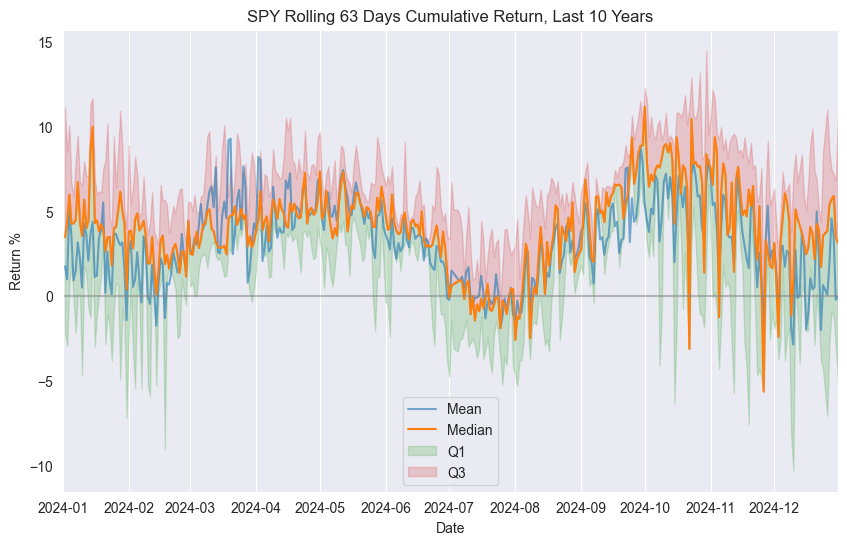

Dickey-Fuller test p-value on mean: 0.18943283616617984
p_value >= 0.05, the mean rolling return data is likely to be non-stationary


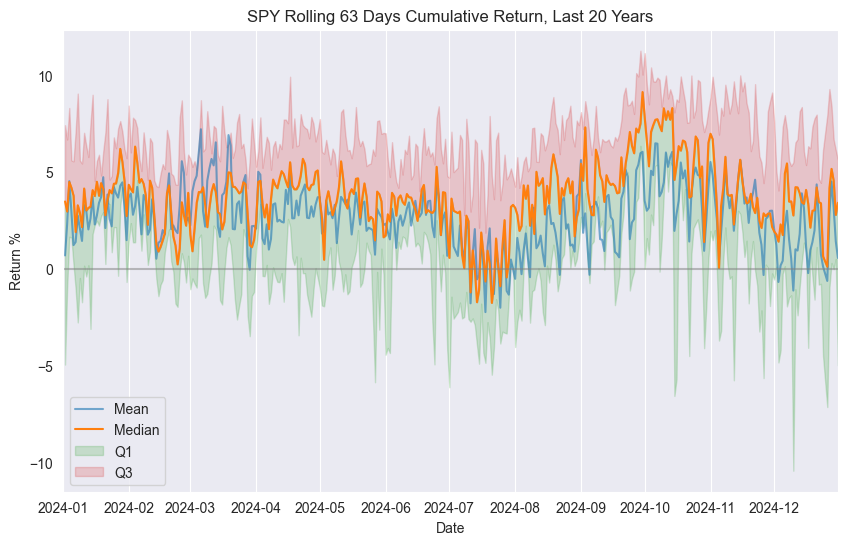

Dickey-Fuller test p-value on mean: 0.0968289789043314
p_value >= 0.05, the mean rolling return data is likely to be non-stationary


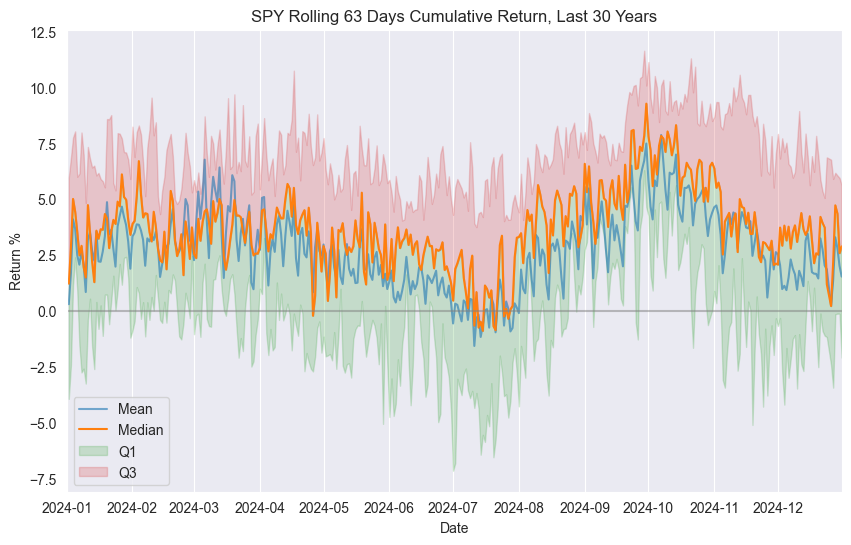

Dickey-Fuller test p-value on mean: 0.40091342446414424
p_value >= 0.05, the mean rolling return data is likely to be non-stationary


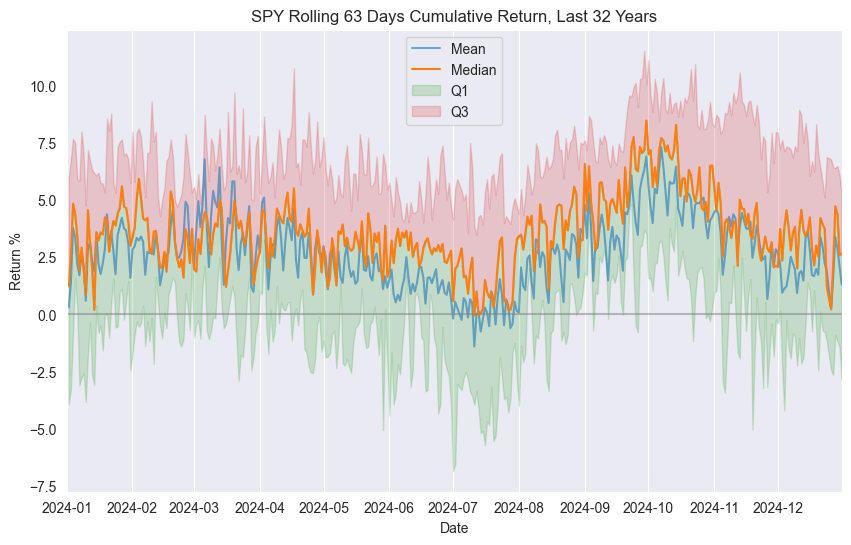

Dickey-Fuller test p-value on mean: 0.27605397604669685
p_value >= 0.05, the mean rolling return data is likely to be non-stationary


In [6]:
final_table = None
for time in choices:
    col_name = 'mean'
    table = plot_graphs(df, 63, time)
    tup = adfuller(table[col_name].dropna())
    test_stats, p_value = tup[0], tup[1]
    print(f'Dickey-Fuller test p-value on {col_name}: {p_value}')
    
    if time == choices[-1]:
        final_table = table
        
    if p_value < 0.05:
        print(f'p_value < 0.05, the {col_name} rolling return data is likely to be stationary')
    else:
        print(f'p_value >= 0.05, the {col_name} rolling return data is likely to be non-stationary')

Distribution

Q1: -0.8443511168289982, Q3: 7.277698070796094, VaR95: -10.718245956726822


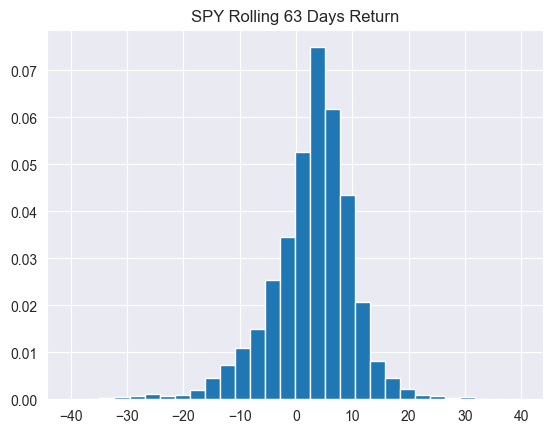

Mean: 2.727667009232907, Std: 7.449700428978334
Skewness: -0.7032096539616369, Kurtosis: 2.8046124110035833
Jarque-Bera test p-value: 0.0
p_value < 0.05, the distribution is likely not normal


In [7]:
x = df['Rolling Return'].dropna() * 100

q1 = np.percentile(x, 25)
q3 = np.percentile(x, 75)
var_95 = np.percentile(x, 5)
print(f'Q1: {q1}, Q3: {q3}, VaR95: {var_95}')
plt.hist(x, bins=30, density=True)
plt.title(f'{name} Rolling 63 Days Return')
plt.show()

# ---- test for normality ----
print(f'Mean: {x.mean()}, Std: {x.std()}')
print(f'Skewness: {x.skew()}, Kurtosis: {x.kurtosis()}')
test_stats, p_value = stats.jarque_bera(x)
print(f'Jarque-Bera test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the distribution is likely not normal')
else:
    print('p_value >= 0.05, the distribution is likely to be normal')

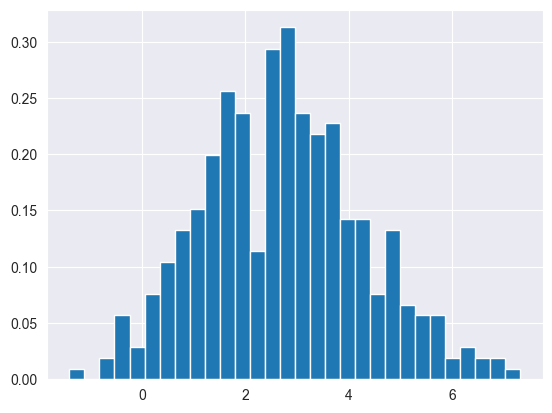

Mean: 2.7190296453423577, Std: 1.5623963487833752
Skewness: 0.22960965402443906, Kurtosis: -0.14275445069883652
Jarque-Bera test p-value: 0.17055428758349686
p_value >= 0.05, the distribution is likely to be normal


In [8]:
x = final_table['mean']

plt.hist(x, bins=30, density=True)
plt.show()

# ---- test for normality ----    Central limit theorem -> get sample of means of means -> approximate normal
print(f'Mean: {x.mean()}, Std: {x.std()}')
print(f'Skewness: {x.skew()}, Kurtosis: {x.kurtosis()}')
test_stats, p_value = stats.jarque_bera(x)
print(f'Jarque-Bera test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the distribution is likely not normal')
else:
    print('p_value >= 0.05, the distribution is likely to be normal')

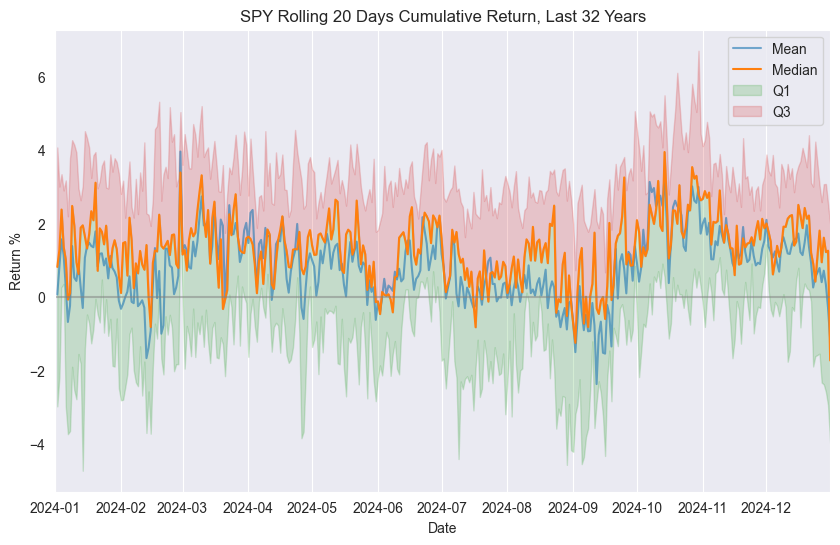

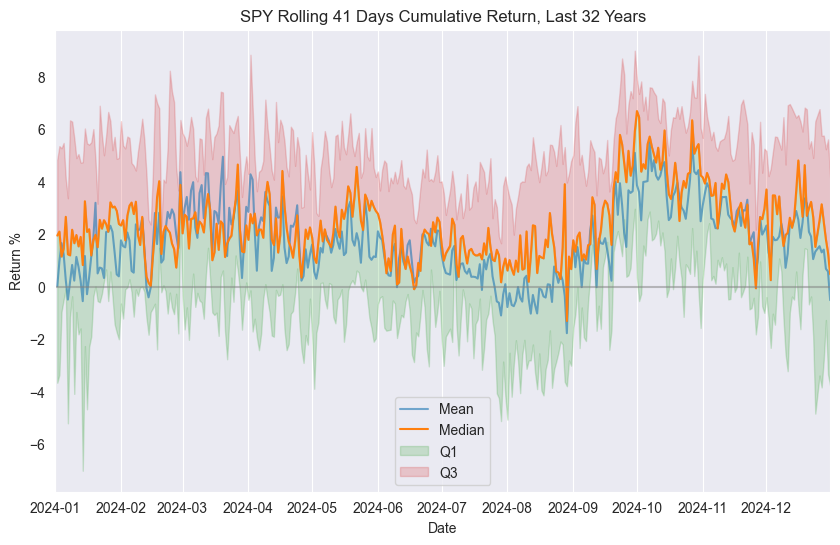

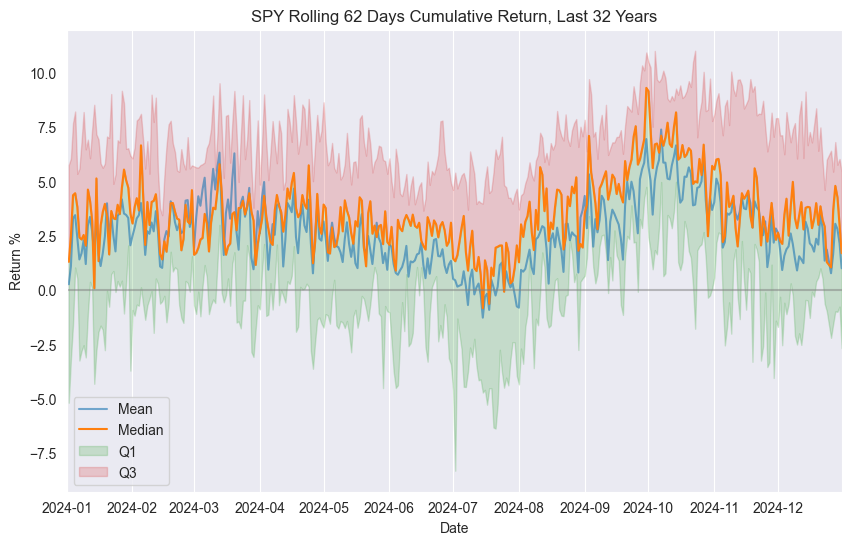

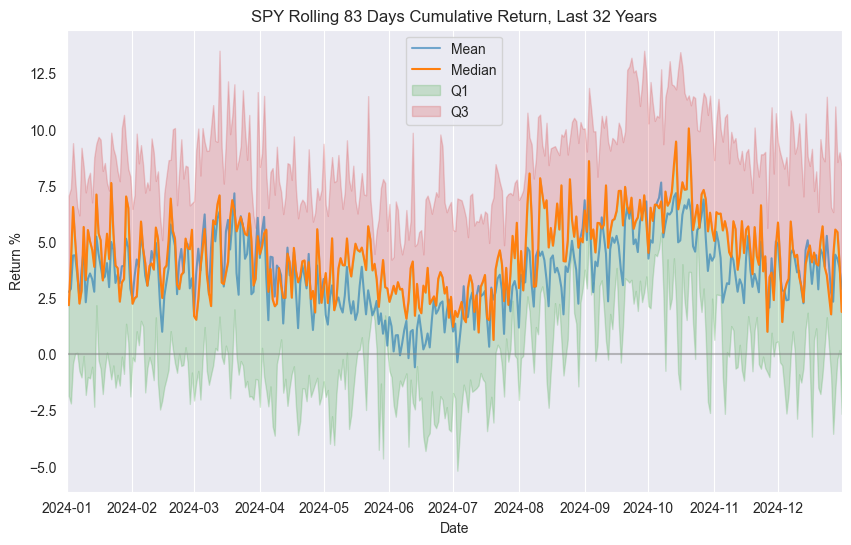

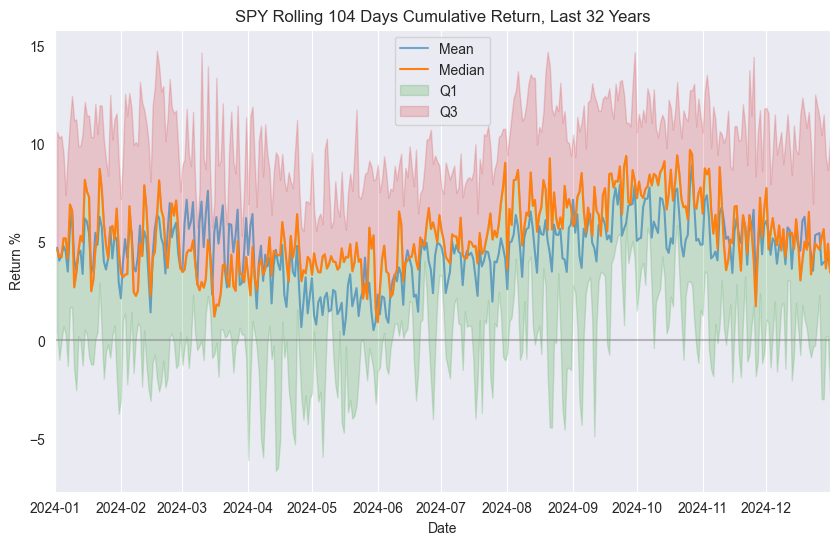

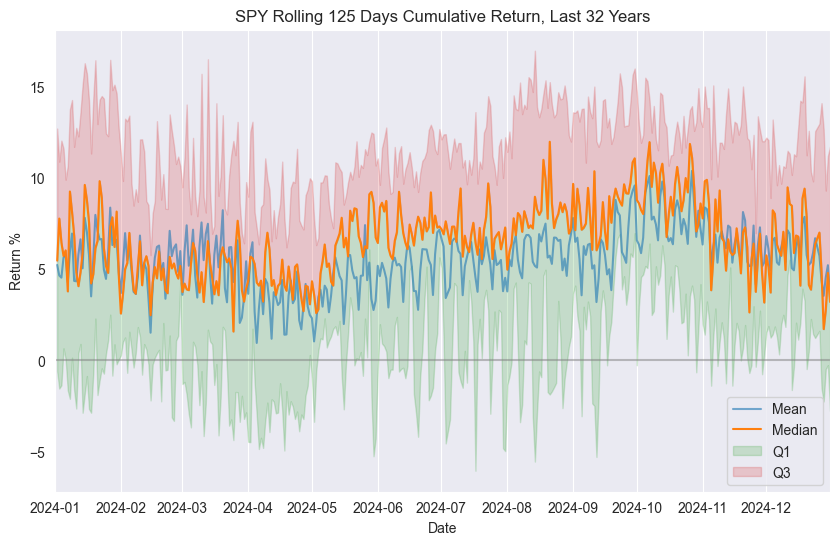

In [9]:
samples = []
temp_list = []
rolling_days = range(20, 126, 21)
for rolling_day in rolling_days:
    temp_df = df.copy()
    for _df in df.rolling(rolling_day):
        if _df.shape[0] != rolling_day: 
            continue
        
        first = _df['Adj Close'].iloc[0]
        last = _df['Adj Close'].iloc[-1]
        returns = (last - first) / first
        temp_list.append(returns)
        
    
    temp_df['Rolling Return'] = temp_list + ([None] * (rolling_day - 1))
    
    temp_list = []
    x = plot_graphs(temp_df, rolling_day, choices[-1])
    samples.append(x)

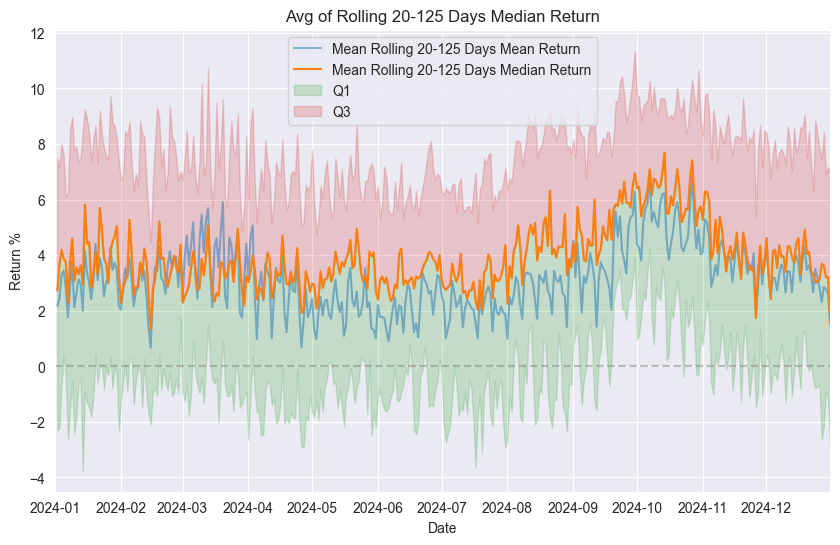

Dickey-Fuller test p-value on means: 0.4374602722570487
p_value >= 0.05, the means rolling return data is likely to be non-stationary


In [10]:
means = [i['mean'] for i in samples]
means = pd.concat(means, axis=1)
means.columns = rolling_days
means_means = means.mean(axis=1)

meds = [i['50%'] for i in samples]
meds = pd.concat(meds, axis=1)
meds.columns = rolling_days
meds_means = meds.mean(axis=1)

q1s = [i['25%'] for i in samples]
q1s = pd.concat(q1s, axis=1)
q1s.columns = rolling_days
q1s_mean = q1s.mean(axis=1)

q3s = [i['75%'] for i in samples]
q3s = pd.concat(q3s, axis=1)
q3s.columns = rolling_days
q3s_mean = q3s.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(means_means, label=f'Mean Rolling {rolling_days[0]}-{rolling_days[-1]} Days Mean Return', alpha=0.5)
plt.plot(meds_means, label=f'Mean Rolling {rolling_days[0]}-{rolling_days[-1]} Days Median Return')
plt.fill_between(q1s_mean.index, q1s_mean, meds_means, label='Q1', alpha=0.2, color=colours[2])
plt.fill_between(q3s_mean.index, q3s_mean, meds_means, label='Q3', alpha=0.2, color=colours[3])
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))
plt.xlabel('Date')
plt.ylabel('Return %')
plt.title(f'Avg of Rolling {rolling_days[0]}-{rolling_days[-1]} Days Median Return')
plt.legend(loc='best')
plt.show()

tup = adfuller(means_means)
test_stats, p_value = tup[0], tup[1]
print(f'Dickey-Fuller test p-value on means: {p_value}')

    
if p_value < 0.05:
    print(f'p_value < 0.05, the means rolling return data is likely to be stationary')
else:
    print(f'p_value >= 0.05, the means rolling return data is likely to be non-stationary')